In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import aux.ts_functions as ts
import seaborn as sns; sns.set()
import numpy as np
import warnings
import os
from scipy.stats import pearsonr
from IPython.display import Image
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import glob
from functools import reduce
from scipy.special import comb
from numpy.linalg import LinAlgError
from matplotlib.offsetbox import AnchoredText
import time
data_dir = "./../data/"

## Functions

### Loading

In [2]:
def get_ts(df, area, specie, toxin, resample_code, plot=True, show_df=False):
    if not isinstance(toxin, list):
        toxin = [toxin]
    ts = df[ (df["Production_Area"]==area) & (biotoxins_ts["Species"]==specie)]
    ts = ts.resample(resample_code).mean()
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(14,7))
        ts.plot(ax=ax, marker='o', markersize=2)
    if show_df: 
        display(ts[toxin].head())
    return ts[toxin]

def get_ts_imputed(area, specie, toxin, suf, data_dir='/imputed_data', only_target=False):
    if suf == "areacorr":
        file_name = suf + '__' + area + '__' + toxin + '_' + specie
    elif suf == "speciecorr":
        file_name = suf + '__' + area + '_' + specie + '__' + toxin
    else:
        raise ValueError(f"Suffix {suf} is not valid.")
        
    file = glob.glob(f'.{data_dir}/{file_name}*.csv')
    if len(file)>1:
        raise ValueError(f"Multiple files found when searching for '{file_name}'")
    elif len(file) == 0:
        raise FileNotFoundError(f"File '{file_name}' found")
    else:
        ts = pd.read_csv(file[0], index_col='Date', parse_dates=True)
        if only_target:
            return ts[[target + '_' + specie]]
        else:
            return ts



### Plot Correlations

In [3]:
from scipy.stats.stats import pearsonr   

def subplot_dim(total, n_cols):
    rows = total//n_cols
    if total%n_cols!=0:
        rows+=1
    return rows, n_cols

def pearson_correlation_species(ts1, ts2, min_seq, min_total):
    values1 = []
    values2 = []
    size = min(len(ts1), len(ts2))
    ts = ts1.isna() | ts2.isna()
    if (~ts).sum() < min_total:
        return None
    i = 0
    while i < size-min_seq+1:
        j = i+min_seq
        if ts[i:j].any(): 
            i+=1
            continue

        while not ts[i:j+1].any() and j!=size:
            j+=1
        
        values1 += ts1[i:j].tolist()
        values2 += ts2[i:j].tolist()

        i=j

    if len(values1) < min_total or len(values2) < min_total:
        return None
    else:
        return pearsonr(values1, values2)[0]
    
def plot_corrs_single_species(species_to_impute, lags, target, suf="speciecorr", type_corr="Pearson",
                                  subplots_per_line=3, use_imputed=True, min_seq=5, min_total=50, annotate=None):

    all_corrs = []
    n_graphics=0
    for area in species_to_impute:
        n_graphics += int(comb(len(species_to_impute[area]), 2))

    rows, columns = subplot_dim(n_graphics, subplots_per_line)
    fig, axes = plt.subplots(rows, columns, 
                             figsize=(8, 3*rows), constrained_layout=True, 
                             sharey=True, squeeze=False)
    axes = axes.ravel()
    ax_iterator=0
    for area in species_to_impute:
        print(area)
        specie_list = []
        for specie in species_to_impute[area]:
            if use_imputed:
                ts = get_ts_imputed(area, specie, target, suf)[[target]]
            else:
                ts = get_ts(biotoxins_ts, area, specie, target, "W", plot=False).interpolate(method="linear")
            specie_list.append(ts)
        df = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, 
                                                     how="outer"),specie_list)
        df.columns = species_to_impute[area]
        #display(df)
        for i in range(len(df.columns)):
            for j in range(i):
                col1, col2 = df.columns[i], df.columns[j]
                print(col1, col2)
                df_corrs = pd.DataFrame({'lags' : lags, 'corrs': np.nan, 'species': '_'.join([col1,col2]),
                                        'pvalue': np.nan, 'annotate':False})
                
                plot = False
                for lag in lags:
                    temp = df.copy()
                    temp[col2] = df[col2].shift(lag)
                    if type_corr.lower() == 'pearson':
                        #corr = temp[col1].corr(temp[col2], method='pearson')
                        #corr = pearson_correlation_species(temp[col1], temp[col2], min_seq, min_total)
                        to_corr = pd.DataFrame({ 'a': temp[col1], 'b': temp[col2] }).dropna()
                        corr, pvalue = pearsonr(to_corr['a'].values, to_corr['b'].values)
                    else:
                        raise ValueError("Invalid type_corr")
                    df_corrs.loc[df_corrs['lags'] == lag, 'corrs'] = corr
                    df_corrs.loc[df_corrs['lags'] == lag, 'pvalue'] = pvalue
                    
                if annotate != None:
                    index_top = df_corrs["corrs"].nlargest(n=annotate).index
                    df_corrs.at[index_top, 'annotate'] = True
                
                sns.lineplot(data=df_corrs, x="lags", y="corrs", marker='o', markersize=4, ax=axes[ax_iterator])
                if type_corr.lower() in ['dpcca', 'dcca']:
                    anchored_text = AnchoredText(f"k={k}", loc='lower left', prop=dict(size=8))
                    axes[ax_iterator].add_artist(anchored_text)
                axes[ax_iterator].set_title(f"{area}\n{' X '.join([col1,col2])}", size="small")
                axes[ax_iterator].tick_params(axis='both', labelsize="x-small")
                axes[ax_iterator].set(xlabel=None, ylabel=None)
                #axes[ax_iterator].set_ylim(-0.2,1)
                axes[ax_iterator].axvline(0, linestyle="--", color="r", linewidth=1)
                
                if annotate!=None:
                    shifts = [-0.3]*(annotate//2) + [0.3]*(annotate - (annotate//2))
                    aligns = ["right"]*(annotate//2) + ["left"]*(annotate - (annotate//2))
                    for line in range(0,df_corrs.shape[0]):
                        if df_corrs["annotate"][line]:
                            axes[ax_iterator].text(df_corrs["lags"][line]+shifts.pop(0), df_corrs["corrs"][line], 
                                    round(df_corrs["pvalue"][line],5), horizontalalignment=aligns.pop(0), 
                                    size='xx-small', color='black')
                    
                ax_iterator += 1
    plt.show()
        
        
        
        
def plot_dpcca_single_species(species_to_impute, lags, target, suf="speciecorr", type_corr="dpcca",
                                  subplots_per_line=3, use_imputed=True, k_range=range(2,21,2)):

    all_corrs = []
    n_graphics=0
    for area in species_to_impute:
        n_graphics += int(comb(len(species_to_impute[area]), 2))

    rows, columns = subplot_dim(n_graphics, subplots_per_line)
    fig, axes = plt.subplots(rows, columns, 
                             figsize=(8, 3*rows), constrained_layout=True, 
                             sharey=True, squeeze=False)
    axes = axes.ravel()
    ax_interator=0
    for area in species_to_impute:
        print(area)
        specie_list = []
        for specie in species_to_impute[area]:
            if use_imputed:
                ts = get_ts_imputed(area, specie, target, suf)[[target]]
                print(ts)
            else:
                ts = get_ts(biotoxins_ts, area, specie, target, "W", plot=False).interpolate(method="linear")
            specie_list.append(ts)
        df = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, 
                                                     how="outer"),specie_list)
        df.columns = species_to_impute[area]
        #display(df)
        for i in range(len(df.columns)):
            for j in range(i):
                col1, col2 = df.columns[i], df.columns[j]
                
                df_corrs = pd.DataFrame(columns=["lags", "corrs","species",'n'])
                for n in k_range:
                    df_corrs = df_corrs.append(pd.DataFrame({'lags':lags, 'corrs':np.nan, 
                                                             'species':'_'.join(sorted([col1,col2])), 'n':str(n)}),
                                                              ignore_index=True)
                #df_corrs = pd.DataFrame({'lags' : lags, 'corrs': np.nan, 'species': '_'.join(sorted([col1,col2]))})
                
            
                plot = False
                for n in k_range:
                    for lag in lags:
                        temp = df.copy()
                        temp[col1] = temp[col1].shift(lag)
                        
                        if type_corr.lower() == 'dpcca':
                            z=3
                        elif type_corr.lower() == 'dcca':
                            z=2
                        else:
                            raise ValueError("Invalid type_corr")
                        corr = compute_dpcca_others(temp.dropna().values, n)[z][0][1]
                        df_corrs.loc[(df_corrs['lags'] == lag) & (df_corrs['n']==str(n)), 'corrs'] = corr
                
                sns.lineplot(data=df_corrs, x="lags", y="corrs", hue="n",marker='o', markersize=4, 
                             ax=axes[ax_interator])
                axes[ax_interator].set_title(f"{area}\n{' X '.join(sorted([col1,col2]))}", size="small")
                axes[ax_interator].tick_params(axis='both', labelsize="x-small")
                axes[ax_interator].set(xlabel=None, ylabel=None)
                #axes[ax_interator].set_ylim(-0.2,1)
                axes[ax_interator].axvline(0, linestyle="--", color="r", linewidth=1)
                axes[ax_interator].legend(prop={'size': 6})
                ax_interator += 1
    plt.show()

### Imputation

In [4]:
def seasonal_mean(ts, n, lr=1):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

# linear, quadratic, cubic, knn, seasonal_year, seasonal_month 
def plot_imputations(ts, target, imputations, begin, end, n_neighbours=10):
    n = len(imputations)
    fig, ax = plt.subplots(n+1,1, figsize=(12,14), constrained_layout=True)
    
    imp = ts[target].interpolate(method="linear")
    imp.plot(ax=ax[0], style='-r')
    ts[target].plot(ax=ax[0], style='-b')
    ax[0].set_title("Example imputation")
    
    i = 1
    if "linear" in imputations:
        imp = ts[target].interpolate(method="linear")
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Linear interpolation")
        i+=1
        
    if "quadratic" in imputations:
        imp = ts[target].interpolate(method="quadratic")
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Quadratic interpolation")
        i+=1
        
    if "cubic" in imputations:
        imp = ts[target].interpolate(method="cubic")
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Cubic interpolation")
        i+=1
        
    if "knn" in imputations:
        imp = pd.Series(data=knn_mean(ts[target], n_neighbours), index=ts[target].index)
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("KNN mean")
        i+=1
        
    if "seasonal_year" in imputations:
        imp = ts.copy()
        imp[target] = seasonal_mean(ts[target], n=52)
        imp = imp[target]
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Seasonal (year) mean")
        i+=1
        
    if "seasonal_month" in imputations:
        imp = ts.copy()
        imp[target] = seasonal_mean(ts[target], n=4)
        imp = imp[target]
        imp[begin:end].plot(ax=ax[i], style='-r', marker='o', markersize=4)
        ts[target][begin:end].plot(ax=ax[i], style='-b', marker='o', markersize=4)
        ax[i].set_title("Seasonal (month) mean")
        i+=1
    
    plt.show()

### DPCCA

In [5]:
# Return sliding windows
def sliding_window(xx,k):
    # Function to generate boxes given dataset(xx) and box size (k)
    import numpy as np

    # generate indexes! O(1) way of doing it :)
    idx = np.arange(k)[None, :]+np.arange(len(xx)-k+1)[:, None]
    return xx[idx],idx

def compute_dpcca_others(cdata,k):
    # Input: cdata(nsamples,nvars), k: time scale for dpcca
    # Output: dcca, dpcca, corr, partialCorr
    #
    # Date(last modification): 02/15/2018
    # Author: Jaime Ide (jaime.ide@yale.edu)
    
    # Code distributed "as is", in the hope that it will be useful, but WITHOUT ANY WARRANTY;
    # without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
    # See the GNU General Public License for more details.
    
    import numpy as np
    from numpy.matlib import repmat
    
    
    # Define
    nsamples,nvars = cdata.shape

    # Cummulative sum after removing mean
    #cdata = signal.detrend(cdata,axis=0) # different from only removing the mean...
    cdata = cdata-cdata.mean(axis=0)
    xx = np.cumsum(cdata,axis=0)
    
    F2_dfa_x = np.zeros(nvars)
    allxdif = []
    # Get alldif and F2_dfa
    for ivar in range(nvars): # do for all vars
        xx_swin , idx = sliding_window(xx[:,ivar],k)
        nwin = xx_swin.shape[0]
        b1, b0 = np.polyfit(np.arange(k),xx_swin.T,deg=1) # linear fit (UPDATE if needed)
        
        #x_hat = [[b1[i]*j+b0[i] for j in range(k)] for i in range(nwin)] # Slower version
        x_hatx = repmat(b1,k,1).T*repmat(range(k),nwin,1) + repmat(b0,k,1).T
    
        # Store differences to the linear fit
        xdif = xx_swin-x_hatx
        allxdif.append(xdif)
        # Eq.4
        F2_dfa_x[ivar] = (xdif**2).mean()
    # Get the DCCA matrix
    dcca = np.zeros([nvars,nvars])
    for i in range(nvars): # do for all vars
        for j in range(nvars): # do for all vars
            # Eq.5 and 6
            F2_dcca = (allxdif[i]*allxdif[j]).mean()
            # Eq.1: DCCA
            dcca[i,j] = F2_dcca / np.sqrt(F2_dfa_x[i] * F2_dfa_x[j])   
    
    # Get DPCCA
    C = np.linalg.inv(dcca)
    
    # (Clear but slow version)
    #dpcca = np.zeros([nvars,nvars])
    #for i in range(nvars):
    #    for j in range(nvars):
    #        dpcca[i,j] = -C[i,j]/np.sqrt(C[i,i]*C[j,j])
    
    # DPCCA (oneliner version)
    mydiag = np.sqrt(np.abs(np.diag(C)))
    dpcca = (-C/repmat(mydiag,nvars,1).T)/repmat(mydiag,nvars,1)+2*np.eye(nvars)
    
    # Include correlation and partial corr just for comparison ;)
    # Compute Corr
    corr = np.corrcoef(cdata.T)
    # Get parCorr
    cov = np.cov(cdata.T)
    C0 = np.linalg.inv(cov)
    mydiag = np.sqrt(np.abs(np.diag(C0)))
    parCorr = (-C0/repmat(mydiag,nvars,1).T)/repmat(mydiag,nvars,1)+2*np.eye(nvars)

    return corr,parCorr,dcca,dpcca

def get_k_for_dpcca(df, k_range, lags, type_corr):
    col1, col2 = df.columns
    corrs_per_k = {}
    for k in k_range:
        max_corr = 0
        for lag in lags:
            df[col1] = df[col1].shift(lag)
            try: 
                if type_corr.lower() == 'dpcca':
                    corr = compute_dpcca_others(df.dropna().values, k)[3][0][1]
                elif type_corr.lower() == 'dcca':
                    corr = compute_dpcca_others(df.dropna().values, k)[2][0][1]
                else:
                    raise ValueError("Invalid type_corr")
            except LinAlgError:
                print("LinAlgError for k = ", k)
                continue
                
            if abs(corr) > max_corr:
                max_corr = abs(corr)
        corrs_per_k[k] = max_corr
    return max(corrs_per_k, key=corrs_per_k.get)


# Loading

In [6]:
biotoxins_ts = pd.read_excel(data_dir + 'biotoxins_preprocessed.xlsx', index_col='Date', parse_dates=True,
                             engine="openpyxl")

ts1 = get_ts(biotoxins_ts, "RIAV1", "Mexilhão", "dsp_toxins", "W", plot=False)
ts2 = get_ts(biotoxins_ts, "LOB", "Mexilhão", "dsp_toxins", "W", plot=False)

ts1.head()

,dsp_toxins
Date,
2015-01-11,52.0
2015-01-18,41.0
2015-01-25,42.0
2015-02-01,35.0
2015-02-08,42.5


# Species

### Pearson

In [7]:
#min vai ser definido pelo total de pontos, estes pontos só são considerados em grupos de pelo menos 'min_seq'
min_seq = 3
min_total = 100
target = "dsp_toxins"
lags = range(-5, 6, 1)

start = time.time()

all_areas = biotoxins_ts["Production_Area"].unique()
species_to_impute = {}
for area in all_areas:
    species_to_impute[area] = []

    s = biotoxins_ts[ biotoxins_ts["Production_Area"] == area]["Species"].unique()

    #print(s,"\n")
    
    for i in range(len(s)):
        for j in range(i):
            ts1 = get_ts(biotoxins_ts, area, s[i], target, "W", plot=False)[target]
            ts2 = get_ts(biotoxins_ts, area, s[j], target, "W", plot=False)[target]
            ind = ts1.index.intersection(ts2.index)
            ts1 = ts1[ind]
            ts2 = ts2[ind]
            corr = pearson_correlation_species(ts1, ts2, min_seq, min_total)
            if corr != None:
                print("#"*10)
                print("#  ",area)
                print("#"*10)
                print(f"{s[i]}&{s[j]} -> {corr}")
                species_to_impute[area]+= [s[i], s[j]]


species_to_impute = {k: v for k, v in species_to_impute.items() if v != []}               
print(species_to_impute)
print("time: ",time.time()-start)
#suf = "speciecorr"
#lags = np.arange(-10, 11, 1)
#target="dsp_toxins"
#plot_corrs_single_species(species_to_impute, lags, target)

##########
#   RIAV2
##########
Mexilhão&Berbigão -> 0.6442842456560136
##########
#   RIAV1
##########
Mexilhão&Berbigão -> 0.40764885409074597
##########
#   L2
##########
Amêijoa-branca&Mexilhão -> 0.4010536955263795
##########
#   LOB
##########
Berbigão&Mexilhão -> 0.2642875625450819
{'RIAV2': ['Mexilhão', 'Berbigão'], 'RIAV1': ['Mexilhão', 'Berbigão'], 'L2': ['Amêijoa-branca', 'Mexilhão'], 'LOB': ['Berbigão', 'Mexilhão']}
time:  9.797247409820557


add conquilha

In [8]:
species_to_impute["OLH2-L9"] = ["Mexilhão", "Conquilha"]
species_to_impute.pop("RIAV1")
species_to_impute

{'RIAV2': ['Mexilhão', 'Berbigão'],
 'L2': ['Amêijoa-branca', 'Mexilhão'],
 'LOB': ['Berbigão', 'Mexilhão'],
 'OLH2-L9': ['Mexilhão', 'Conquilha']}

In [11]:
#species_to_impute.pop("LOB")

KeyError: 'LOB'

RIAV2
Berbigão Mexilhão
L2
Mexilhão Amêijoa-branca
OLH2-L9
Conquilha Mexilhão


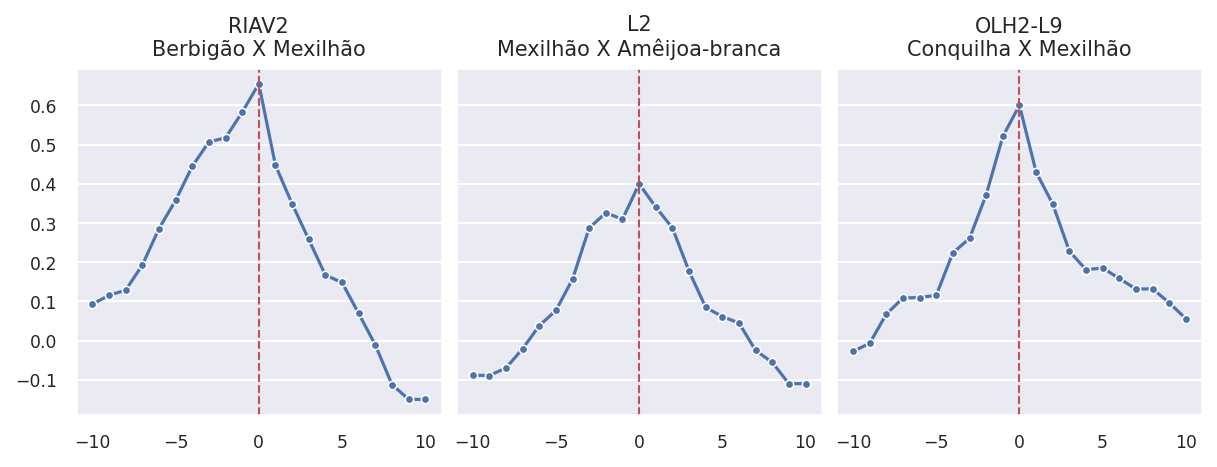

In [14]:
lags = np.arange(-10, 11, 1)
target="dsp_toxins"
plot_corrs_single_species(species_to_impute, lags, target, subplots_per_line=3, annotate=0)

### DPCCA

{'RIAV2': ['Mexilhão', 'Berbigão'], 'L2': ['Amêijoa-branca', 'Mexilhão'], 'OLH2-L9': ['Mexilhão', 'Conquilha']}
RIAV2
            dsp_toxins
Date                  
2015-01-11        49.0
2015-01-18        73.0
2015-01-25        58.0
2015-02-01        49.0
2015-02-08        68.0
...                ...
2020-11-22       295.0
2020-11-29       270.0
2020-12-06       245.0
2020-12-13       220.0
2020-12-20       195.0

[311 rows x 1 columns]
            dsp_toxins
Date                  
2015-01-11        26.0
2015-01-18        43.0
2015-01-25        19.0
2015-02-01        18.0
2015-02-08        34.5
...                ...
2020-12-06        36.0
2020-12-13        36.0
2020-12-20        36.0
2020-12-27        36.0
2021-01-03        36.0

[313 rows x 1 columns]
L2
            dsp_toxins
Date                  
2015-01-11   16.000000
2015-01-18   26.000000
2015-01-25   29.333333
2015-02-01   36.000000
2015-02-08   31.000000
...                ...
2020-11-29   36.000000
2020-12-06   57.000000
202

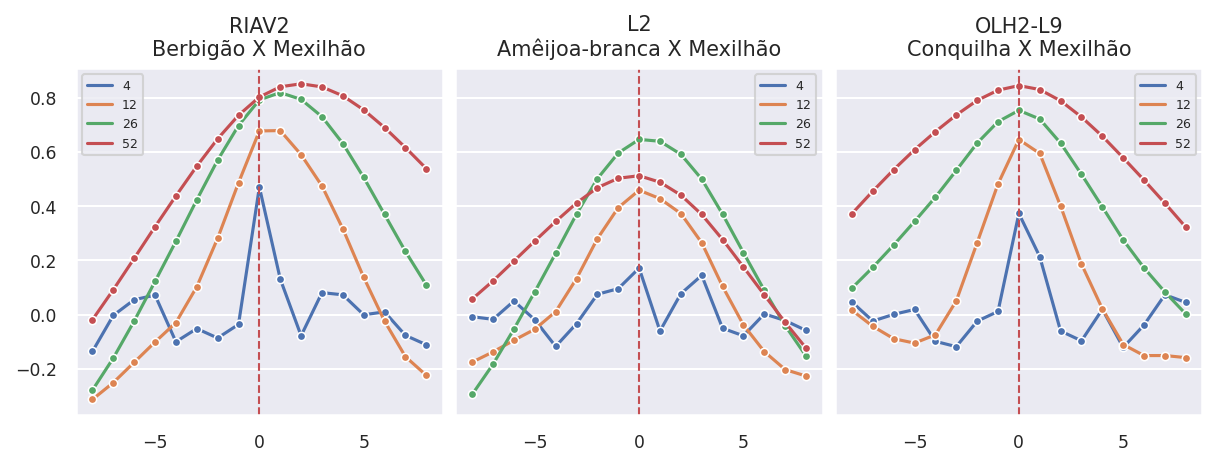

In [16]:
all_areas = biotoxins_ts["Production_Area"].unique()
min_per_specie = 200
#species_to_impute = {}
#for area in all_areas:
#    vc = biotoxins_ts[ biotoxins_ts["Production_Area"] == area]["Species"].value_counts()
#    vc = vc[vc > min_per_specie]
#    if len(vc)>1:
#        species_to_impute[area] = vc.keys().tolist()

print(species_to_impute)

suf = "speciecorr"
lags = np.arange(-8, 9, 1)
target="dsp_toxins"
plot_dpcca_single_species(species_to_impute, lags, target, k_range=[4, 12, 26, 52], subplots_per_line=3)